# Funnel Analysis
## Goal
Perform **funnel analysis** for an e-commerce website.

Typically, websites have a clear path of conversion: for most cases, user first land on the home page(may through various kinds of channels:ogranic search, email, google, etc), then do the search or browse the items/service provided at homepage, then select the item and purchase it. While the entire process may not be done by once or a single period of time, it might takes users several days, repeating some steps several times, before they eventually place the order. During each step, there are users drop off and leave the site. The sequence of pages that lead to conversion is called 'funnel'.

**Funnel Analysis** allows us to understand where/when and what kind of users leave the websites, which gives crucial insights on our user behavior analysis, thus providing recommendations and solutions to improve user experience and increase the conversion rate.

## Problem Description
One website has only 4 pages: homepage, search page, payment page, confirmation page. The CEO wants to improve the conversion rate and asked you to investigate whether there is sth wrong in the conversion funnel. In general, she is interested in:
* A full picture of funnel conversion rate for both desktop and mobile
* Some insights on what the product team should focus on to improve the conversion rate, or anything else.
### 1.Load in data

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from os import listdir
import datetime as dt

In [14]:
#four page
home_df = pd.read_csv('home_page_table.txt', sep = ',', header = 0)
search_df = pd.read_csv('search_page_table.txt', sep = ',', header = 0)#45200
payment_df = pd.read_csv('payment_page_table.txt', sep = ',', header = 0)#6030
confirm_df = pd.read_csv('payment_confirmation_table.txt', sep = ',', header = 0)#452

In [15]:
print('home table', home_df.head(3), 'how many', home_df.shape[0])
print('search table', search_df.head(3), 'how many', search_df.shape[0])
print('payment table', payment_df.head(3),'how many', payment_df.shape[0])
print('confirm table', confirm_df.head(3),'how many', confirm_df.shape[0])

home table    user_id       page
0   313593  home_page
1   468315  home_page
2   264005  home_page how many 90400
search table    user_id         page
0    15866  search_page
1   347058  search_page
2   577020  search_page how many 45200
payment table    user_id          page
0   253019  payment_page
1   310478  payment_page
2   304081  payment_page how many 6030
confirm table    user_id                       page
0   123100  payment_confirmation_page
1   704999  payment_confirmation_page
2   407188  payment_confirmation_page how many 452


In [52]:
#get the final page
page_df = home_df.copy()
page_df.loc[search_df.index, 'page'] = search_df.page
page_df.loc[payment_df.index, 'page'] = payment_df.page
page_df.loc[confirm_df.index, 'page'] = confirm_df.page
page_df.rename(columns = {'page' :'final_page'}, inplace= True)

In [58]:
page_df.sample(10)

,user_id,final_page
71784,505319,home_page
12566,460013,search_page
1954,682753,payment_page
64618,664569,home_page
62509,463583,home_page
46731,574941,home_page
13610,848989,search_page
9719,983025,search_page
73604,914281,home_page
35572,316580,search_page


In [18]:
#user information
user_df = pd.read_csv('user_table.txt', sep = ',', header= 0)

In [19]:
print('user table', user_df.head(3),'how many', user_df.shape[0])

user table    user_id        date   device     sex
0   450007  2015-02-28  Desktop  Female
1   756838  2015-01-13  Desktop    Male
2   568983  2015-04-09  Desktop    Male how many 90400


In [152]:
#merge page information into user table, 
# 1.final page
#user_page_df = user_df.merge(page_df, on = 'user_id', how = 'left')
# 2. all pages
user_page = user_df.merge(search_df.rename(columns = {'page':'search_page'}), on = 'user_id', how = 'left').merge(payment_df.rename(columns = {'page':'payment_page'}), on = 'user_id', how = 'left').merge(confirm_df.rename(columns = {'page':'confirm_page'}), on = 'user_id', how = 'left')

In [60]:
user_page_df.sample(4)

,user_id,date,device,sex,final_page
61953,854169,2015-04-22,Desktop,Female,home_page
9702,456631,2015-01-27,Mobile,Female,home_page
624,787925,2015-02-18,Mobile,Female,home_page
52272,23637,2015-02-04,Desktop,Male,search_page


In [64]:
#convert to datetime
#user_page_df.date = pd.to_datetime(user_page_df.date)
user_page_df.dtypes

user_id                int64
date          datetime64[ns]
device                object
sex                   object
final_page            object
dtype: object

In [154]:
user_page = user_page.fillna(0)
user_page.search_page = np.where(user_page.search_page !=0, 1, 0)
user_page.payment_page = np.where(user_page.payment_page !=0, 1, 0)
user_page.confirm_page = np.where(user_page.confirm_page !=0, 1, 0)

In [155]:
user_page.sample(5)

,user_id,date,device,sex,search_page,payment_page,confirm_page
13909,449273,2015-01-10,Mobile,Male,1,0,0
10121,546039,2015-02-08,Desktop,Female,1,0,0
81066,581621,2015-04-03,Desktop,Male,0,0,0
83622,762479,2015-03-27,Desktop,Female,1,0,0
44441,731734,2015-01-25,Desktop,Female,1,0,0


In [159]:
sum(user_page.search_page !=0)

45200

In [65]:
#save merged data
user_page_df.to_csv('user_page.csv', index_label ='user_id')
user_page.to_csv('user_page_total.csv', index_label = 'user_id')

### A full picture of funnel conversion rate for both desktop and mobile

In [165]:
user_page_df.final_page.value_counts()
#event = user_page_df.final_page.value_counts().index


home_page                    45200
search_page                  39170
payment_page                  5578
payment_confirmation_page      452
Name: final_page, dtype: int64

In [170]:
user_page_df.final_page.value_counts().loc['search_page']

39170

In [173]:

def conversion_rate(df):
    event_count = df.final_page.value_counts()
    total_n = df.shape[0]
    convert_from = event_count.copy()
    for page in event_count.index:
        #how many people hit to current page
        current_n = event_count.loc[page]
        #how many people left website at this page
        left_n = total_n - current_n
        convert_from[page] = left_n
        total_n = current_n
    
    c_rate = pd.concat([event_count, convert_from], axis = 1, keys = ['convert_n', 'drop_n'])
    c_rate['conversion_rate'] = c_rate.convert_n.astype(np.float)/(c_rate.drop_n+c_rate.convert_n)
    c_rate['drop_rate'] = 1-c_rate.conversion_rate
    return c_rate

In [174]:
user_page_df.groupby('device').apply(conversion_rate)

convert_n  drop_n  conversion_rate  \
device                                                                  
Desktop home_page                      30127   30073         0.500449   
        search_page                    26057    4070         0.864905   
        payment_page                    3717   22340         0.142649   
        payment_confirmation_page        299    3418         0.080441   
Mobile  home_page                      15073   15127         0.499106   
        search_page                    13113    1960         0.869966   
        payment_page                    1861   11252         0.141920   
        payment_confirmation_page        153    1708         0.082214   

                                   drop_rate  
device                                        
Desktop home_page                   0.499551  
        search_page                 0.135095  
        payment_page                0.857351  
        payment_confirmation_page   0.919559  
Mobile  home_page                   0.500894  
        search_page                 0.130034  
        payment_page                0.858080  
        payment_confirmation_page   0.917786

In [221]:
user_page_df.groupby('device')['final_page'].apply(lambda x: x.value_counts(normalize = True))


device                            
Desktop  home_page                    0.500449
         search_page                  0.432841
         payment_page                 0.061744
         payment_confirmation_page    0.004967
Mobile   home_page                    0.499106
         search_page                  0.434205
         payment_page                 0.061623
         payment_confirmation_page    0.005066
Name: final_page, dtype: float64

In [223]:
user_page_df.groupby('sex').apply(conversion_rate)

convert_n  drop_n  conversion_rate  \
sex                                                                    
Female home_page                      22589   22486         0.501143   
       search_page                    19470    3119         0.861924   
       payment_page                    2782   16688         0.142886   
       payment_confirmation_page        234    2548         0.084112   
Male   home_page                      22611   22714         0.498864   
       search_page                    19700    2911         0.871257   
       payment_page                    2796   16904         0.141929   
       payment_confirmation_page        218    2578         0.077969   

                                  drop_rate  
sex                                          
Female home_page                   0.498857  
       search_page                 0.138076  
       payment_page                0.857114  
       payment_confirmation_page   0.915888  
Male   home_page                   0.501136  
       search_page                 0.128743  
       payment_page                0.858071  
       payment_confirmation_page   0.922031

In [176]:
user_page_df.groupby('sex').apply(conversion_rate)

convert_n  drop_n  conversion_rate  \
sex                                                                    
Female home_page                      22589   22486         0.501143   
       search_page                    19470    3119         0.861924   
       payment_page                    2782   16688         0.142886   
       payment_confirmation_page        234    2548         0.084112   
Male   home_page                      22611   22714         0.498864   
       search_page                    19700    2911         0.871257   
       payment_page                    2796   16904         0.141929   
       payment_confirmation_page        218    2578         0.077969   

                                  drop_rate  
sex                                          
Female home_page                   0.498857  
       search_page                 0.138076  
       payment_page                0.857114  
       payment_confirmation_page   0.915888  
Male   home_page                   0.501136  
       search_page                 0.128743  
       payment_page                0.858071  
       payment_confirmation_page   0.922031

In [217]:
#plot the conversion funnel by barplot
def get_plot(df, var):
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111)
    p = df.groupby(var)['final_page'].apply(lambda x: x.value_counts(normalize = True))
    pp = p.unstack()
    pp.plot(kind = 'bar', ax=ax, width = 0.9)
    plt.title('Conversion Rate of ' + var, fontsize = 18)
    plt.xlabel(var, fontsize = 16)
    plt.xticks(fontsize = 16, rotation = 'vertical')
    plt.yticks(fontsize = 15)
    plt.ylabel('conversion_rate', fontsize = 15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
    for x in range(0,df.shape[0]):
        p.text(df[var][x]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    print(pp)


         home_page  search_page  payment_page  payment_confirmation_page
device                                                                  
Desktop   0.500449     0.432841      0.061744                   0.004967
Mobile    0.499106     0.434205      0.061623                   0.005066


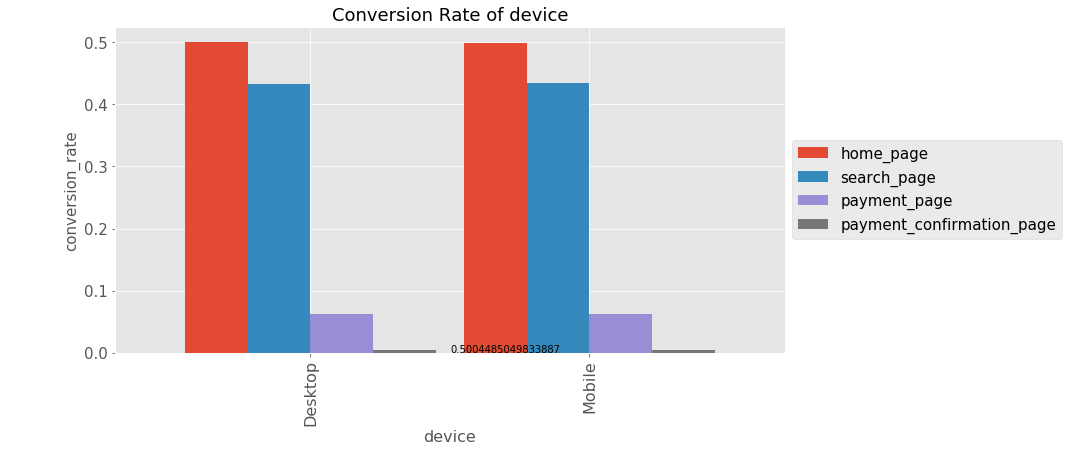

In [218]:
get_plot(user_page_df, 'device')

        home_page  search_page  payment_page  payment_confirmation_page
sex                                                                    
Female   0.501143     0.431947      0.061719                   0.005191
Male     0.498864     0.434639      0.061688                   0.004810


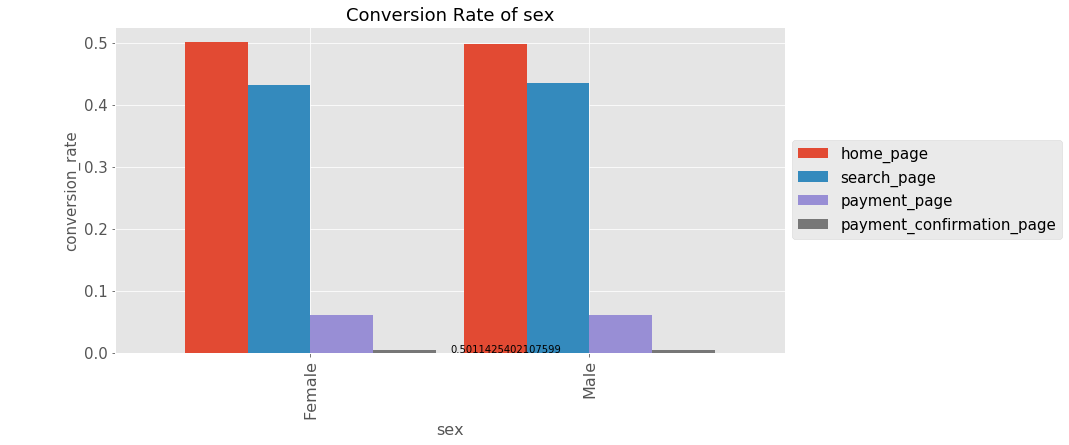

In [219]:
get_plot(user_page_df, 'sex')

There is no too much difference between desktop and mobile, female and male.

But we can see from the conversion plot, there is huge decrease between search and pay, which indicates many users DID search, but CANNOT find the item they want, so they left.

### Other insights from EDA and Mining

In [220]:
#1. device
user_page_df.device.value_counts()
#Although the number of user in desktop is twice much as mobile, but the conversion 
#rate is not too different from each other

Desktop    60200
Mobile     30200
Name: device, dtype: int64

In [224]:
# 2. sex
user_page_df.sex.value_counts()
# female and male user are almost half half, which indicates the item on this website
#has no gender distinguishment

Male      45325
Female    45075
Name: sex, dtype: int64

In [225]:
# 3.date
user_page_df.date.describe()
#4 month records from 2015-01-01 to 2015-04-30

count                   90400
unique                    120
top       2015-02-08 00:00:00
freq                      877
first     2015-01-01 00:00:00
last      2015-04-30 00:00:00
Name: date, dtype: object

In [228]:
user_page_df['weekday'] = user_page_df.date.dt.weekday_name

In [229]:
user_page_df.sample(8)

,user_id,date,device,sex,final_page,weekday
41114,503881,2015-02-05,Desktop,Female,search_page,Thursday
34486,42869,2015-04-03,Desktop,Male,home_page,Friday
49798,302482,2015-02-25,Desktop,Female,payment_page,Wednesday
52125,769578,2015-01-11,Desktop,Male,payment_page,Sunday
71159,134838,2015-01-12,Mobile,Male,home_page,Monday
66704,841278,2015-02-25,Mobile,Male,home_page,Wednesday
58735,549849,2015-04-22,Mobile,Male,search_page,Wednesday
19578,682210,2015-02-26,Desktop,Female,search_page,Thursday
